# Model Deployment and Testing

This notebook will guide you through the complete workflow of deploying and validating your model.
The steps include:

1. Authentication

2. Retrieving the trained model

3. Creating the PyTorch Model in SageMaker

4. Deploying the model to an endpoint

5. Running inference tests to validate the deployment

In [ ]:
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch

boto_session = boto3.Session(profile_name='pessoal', region_name='us-east-1')
bucket_name = 'sagemaker-portfolio-cv-aws' 
sess = sagemaker.Session(boto_session=boto_session, default_bucket=bucket_name)
region = sess.boto_region_name

print(f"Region: {region}")
print(f"Target bucket: {bucket_name}")

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\josel\AppData\Local\sagemaker\sagemaker\config.yaml
Região: us-east-1
Bucket alvo: sagemaker-portfolio-cv-aws


In [ ]:
import sys
sys.path.append(os.path.abspath(".."))
from config_private import IAM_ROLE
role = IAM_ROLE

## Retrieve the Trained Model

In this step, we access the model artifact that was generated during the training process and stored in Amazon S3.
This artifact typically contains the trained weights, model configuration, and any additional files required for deployment.

In [ ]:
training_job_name = 'pytorch-training-2025-11-20-17-03-50-691' 

desc = boto_session.client('sagemaker').describe_training_job(TrainingJobName=training_job_name)
model_data_s3 = desc['ModelArtifacts']['S3ModelArtifacts']

print(f"Artifact found at: {model_data_s3}")

Artefato do modelo encontrado em: s3://sagemaker-portfolio-cv-aws/pytorch-training-2025-11-20-17-03-50-691/output/model.tar.gz


## Create PytorchModel

In [10]:
from sagemaker.pytorch import PyTorchModel

model = PyTorchModel(
    model_data=model_data_s3,
    role=role,
    entry_point='inference.py',
    source_dir='../../sagemaker_entry_point/hymenoptera',
    framework_version='2.6.0',
    py_version='py312',
    sagemaker_session=sess
)

print("Fazendo Deploy...")

# Deploy em uma máquina pequena e barata (ml.t2.medium)
predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=sagemaker.serializers.IdentitySerializer(content_type='application/x-image') # Envia bytes puros
)

Fazendo Deploy...
------------!

In [13]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
endpoint_name = 'pytorch-inference-2025-11-20-19-02-29-473'
predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
    
    serializer=IdentitySerializer(content_type='application/x-image'),
    deserializer=JSONDeserializer()
)

## Testing the API

In [ ]:
import os

test_image_path = '../../data/raw/hymenoptera_data/val/ants/153783656_85f9c3ac70.jpg'

with open(test_image_path, 'rb') as f:
    image_bytes = f.read()

response = predictor.predict(image_bytes)

print(f"Raw model response: {response}")

# Process the result
import numpy as np
classes = ['ant', 'bee']
result_index = np.argmax(response)
confidence = response[0][result_index]

print(f"\nPrediction: {classes[result_index]}")

Resposta bruta do modelo: [[-0.051442332565784454, 0.11594817787408829]]

Previsão: abelha


In [ ]:
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='application/x-image',
    Body=image_bytes
)

result = response['Body'].read()
print(f"Raw response (bytes): {result}")

import json
try:
    print("Decoded response:", json.loads(result))
except:
    print("Decoded response (text):", result.decode('utf-8'))

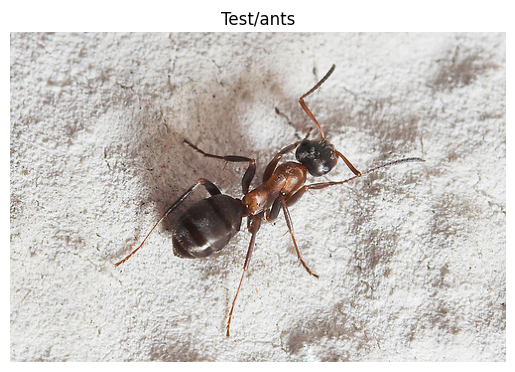

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Visualizando algumas imagens de treino
img = mpimg.imread(test_image_path)
plt.imshow(img)
plt.title("Test/ants")
plt.axis('off')
plt.show()

## Shutingdown the endpoint

In [ ]:
predictor.delete_endpoint()
print("Shutdown complete.")

Endpoint deletado. Sem custos extras.
